# Finding the "needle in the haystack" galaxies¶
A python excersie notebook written by Lewis McMillan, Summer 2020. This notebook has benifited from examples provided by Rita Tojeiro, and the help of Anne-Marie Weijmans, and Simon Reynolds.

In this notebook you will use data from the Sloan Digital Sky Survey (SDSS), to explore how astronomers interact with "big data", and how they can use various different measurments of galaxies shapes in order to find spiral galaxies, the mergering of multiple galaxies, and other interesting galaxies.

## SDSS and SciServer
As mentioned above, in this notebook we will use data from SDSS, which is is the largest astronmical dataset in the world currently. For eachs nights observing it generates around 200Gb of data. The laptop this notebook was written on has 256Gb of storage space, meaning that I could fit 1 nights observing data on my laptop with some space left over for all the programs I need to analysie the data.

If you are reading this then we assume that you havel alredy followed the instructions to get an account on SciServer, and have uploaded this notebook. In addition to this we assume that you are familiar with basic python, dataframe manipulation, and matplotlib commands. If not please complete Rita Tojeiro's notebook's which cover these topics: link here

## Install required Python libraries
The following prompt only needs to be run once

In [3]:
# move to correct folder
%cd ..
import pawlikMorphLSST as pmlsst                    # Library for analysing galaxies
print("Galaxy analysis code imported")
# move back to original folder
%cd -

# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs                 # query with CasJobs
import SciServer.SkyServer as SkyServer
print('SciServer libraries imported')

# Import other libraries for use in this notebook.
import numpy as np                                  # standard Python lib for math ops
import pandas as pd                                 # data manipulation package
import matplotlib.pyplot as plt                     # another graphing package
from pathlib import Path                            # manage local files in your Compute containers
from astropy.visualization import ZScaleInterval    # for plotting clear images
from tqdm import tqdm_notebook                      # for a nice progress bar
from concurrent.futures import ProcessPoolExecutor  # for running the code on more than 1 cpu
from IPython.display import clear_output            # allow nice printing
import json
print('Supporting libraries imported')

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pd.set_option('display.max_colwidth', -1)

# for plotting clear images
zscale = ZScaleInterval()

# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

/home/idies/workspace/Storage/0000_0002_7725_5162/persistent/outreach
Galaxy analysis code imported
/home/idies/workspace/Storage/0000_0002_7725_5162/persistent/outreach/notebooks
SciServer libraries imported
Supporting libraries imported
Settings applied


In [4]:
# Find objects in the Sloan Digital Sky Survey's.
#
# Query the Sloan Digital Sky Serveys' NSA catalog of galactical objects.
# For the database schema and documentation see http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx?cmd=description+nsatlas+U#&&history=description+nsatlas+U
#
# This query finds all galaxies in the value added catalogue PawlikMorph and matches this information to the
# MaNGA catalogue in order to get galaxies positions.
# Finally we discard any galaxies that have incomplete measurments
#
# First, store the query in an object called "query"
query="""
select distinct m.objra, m.objdec, p.run, p.rerun, p.camcol, p.field
from dbo.PawlikMorph p
  join dbo.mangaDAPall m
  on m.mangaID = p.mangaid
"""

#Then, query the database. The answer is a table that is being returned to a dataframe that we've named all_gals.
all_gals = CasJobs.executeQuery(query, "dr16")

print("SQL query finished.")
print(f"SQL query returned {len(all_gals.index)} galaxies")

SQL query finished.
SQL query returned 4603 galaxies


In [6]:
# add a column to the dataframe, which contains the path to the image
def makename(df):
    root = "/home/idies/workspace/sdss_das/das2/imaging/"
    df["fname"] = df.apply(lambda row: root + f"{int(row.run)}/{int(row.rerun)}/corr/{int(row.camcol)}/fpC-{int(row.run):06}-r{int(row.camcol)}-{int(row.field):04}.fit.gz", axis=1)
    return df

# add filename column
all_gals = makename(all_gals)
# View the information of the first 10 galaxies retrieved
all_gals[0:10]

,objra,objdec,run,rerun,camcol,field,fname
0,182.857361,44.436020,3813,41,2,217,/home/idies/workspace/sdss_das/das2/imaging/3813/41/corr/2/fpC-003813-r2-0217.fit.gz
1,311.347351,0.492529,2583,40,5,56,/home/idies/workspace/sdss_das/das2/imaging/2583/40/corr/5/fpC-002583-r5-0056.fit.gz
2,166.311935,49.658909,2964,40,6,242,/home/idies/workspace/sdss_das/das2/imaging/2964/40/corr/6/fpC-002964-r6-0242.fit.gz
3,172.492081,52.183121,2883,40,4,150,/home/idies/workspace/sdss_das/das2/imaging/2883/40/corr/4/fpC-002883-r4-0150.fit.gz
4,138.796524,29.252195,3900,41,2,114,/home/idies/workspace/sdss_das/das2/imaging/3900/41/corr/2/fpC-003900-r2-0114.fit.gz
5,192.421753,44.299358,3813,41,2,263,/home/idies/workspace/sdss_das/das2/imaging/3813/41/corr/2/fpC-003813-r2-0263.fit.gz
6,136.793854,46.211147,2863,40,3,100,/home/idies/workspace/sdss_das/das2/imaging/2863/40/corr/3/fpC-002863-r3-0100.fit.gz
7,208.392609,38.996597,3893,41,1,295,/home/idies/workspace/sdss_das/das2/imaging/3893/41/corr/1/fpC-003893-r1-0295.fit.gz
8,197.580139,32.023403,4623,40,4,242,/home/idies/workspace/sdss_das/das2/imaging/4623/40/corr/4/fpC-004623-r4-0242.fit.gz
9,175.948654,54.707497,3103,40,4,121,/home/idies/workspace/sdss_das/das2/imaging/3103/40/corr/4/fpC-003103-r4-0121.fit.gz


In [6]:
# This snippet create a list of filenames, and positions that analyseImage requires to run
info = []
for i in range(0, len(all_gals.index)):
    ra, dec = all_gals["objra"].iloc[i], all_gals["objdec"].iloc[i]
    name = all_gals["fname"].iloc[i]
    info.append([name, ra, dec])

In [6]:
def processResult(results):
    processedResults = {"A": [], "As": [], "As90": [], "C": [], "S": [], "g": [], "m20": [], "fname": [], "radec": []}
    for result in results:
        if result[0] != -99:
            processedResults["A"].append(result[0])
            processedResults["As"].append(result[1])
            processedResults["As90"].append(result[2])
            processedResults["C"].append(result[3])
            processedResults["S"].append(result[4])
            processedResults["g"].append(result[5])
            processedResults["m20"].append(result[6])
            processedResults["fname"].append(result[7])
            processedResults["radec"].append((result[8], result[9]))
    return processedResults

In [7]:
cores = 16
results = []
with ProcessPoolExecutor(max_workers=cores) as pool:
    for result in tqdm_notebook(pool.map(pmlsst.helpers.analyseImage, info), total=len(info)):
        results.append(result)
finalResults = processResult(results)
json.dump(finalResults, open("results.json", "w"))

If your code crashes, or this work is completed over more than one afternoon, you can reload the results using the below code in order to save time.

In [7]:
finalResults = json.load(open("results.json"))

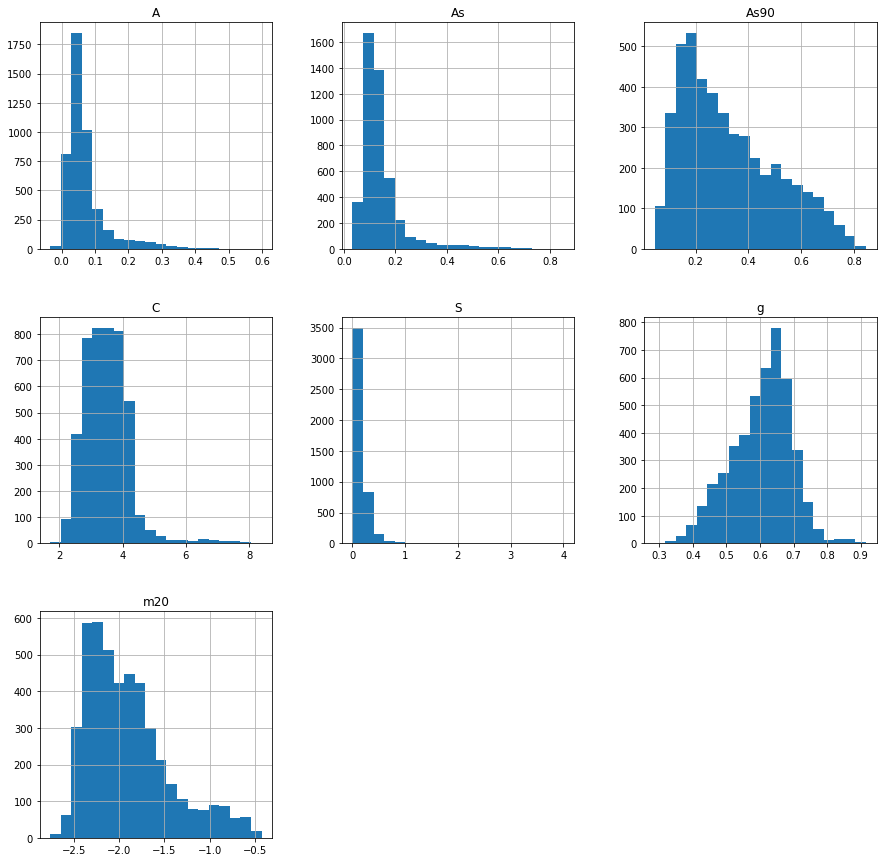

In [8]:
df = pd.DataFrame.from_dict(finalResults)
hist = df.hist(bins=20, figsize=(15,15))

# Finding the "needle galaxy" in the universe 
We introduced the asymmetry measures A, and As in the last notebook. To refresh your memory, A is better at finding the asymmery of the internal stuctures of galaxies, where as As is better at finding asymmetry in the overall shape of a galaxy and does not anayse the internal structure at all.

## Exercise
Make sure to use appropriate labels and titles in your plots.
1. Make a scatter plot of A vs As
2. Make histogram plots of A, and As.
3. By inspection of the above plots, define thresholds for A, and As in which the majortiy of points fall under. Then split the dataset into major and minority subsets. Plot these subsets as you did in Q1, but explicitly colouring the different subsets.
4. For the minority subset, plot the colour images for 9 galaxies with extreme A and As.
5. For each of the 9 images plotted in the previous question, comment on whether you belive they are morphological disturbed, or are "normal" galaxies with some object "contanminating" the analysis. Some images may be faint so it may be advisable to plot the masks or science image of these.

Text(0, 0.5, 'As')

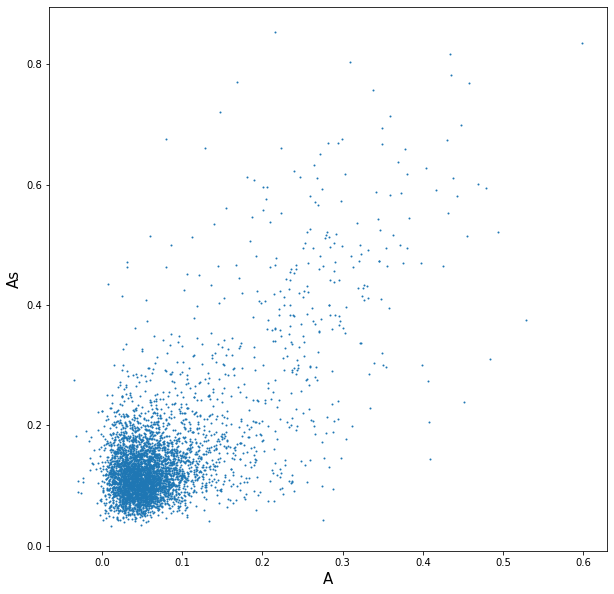

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(df["A"], df["As"], s=1)
ax.set_xlabel("A", fontsize=15)
ax.set_ylabel("As", fontsize=15)

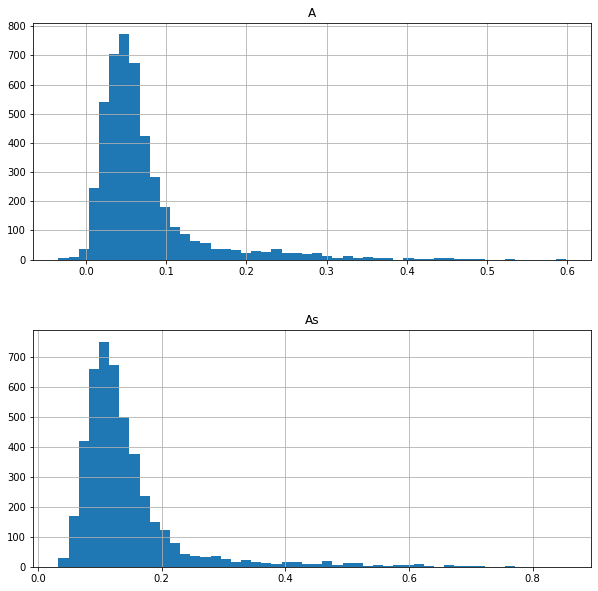

In [10]:
ax = df.hist(bins=50, column=["A", "As"], figsize=(10, 10), layout=(2, 1))

minor subset size:  636
major subset size:  3948


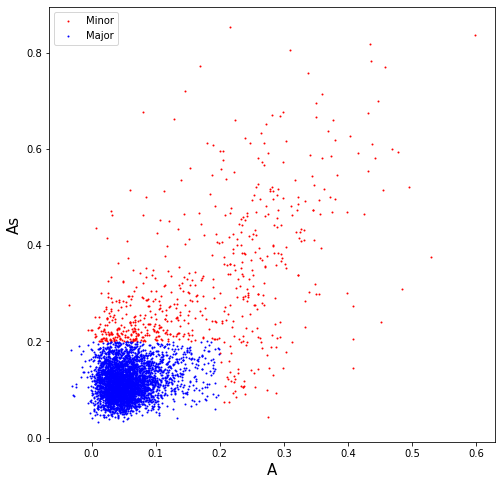

In [11]:
# students answer should be 0.2 <= As <= 2.5, 0.125 <= As <= 0.25

# define threshold as 0.2 for both
minor = df.query("A > 0.2 | As > 0.2")
major = df.query("A <= 0.2 & As <= 0.2")
print("minor subset size: ", len(minor.index))
print("major subset size: ",len(major.index))

fig, axs = plt.subplots(figsize=(8, 8))
axs.scatter(minor["A"], minor["As"], color="red", label="Minor", s=1)
axs.scatter(major["A"], major["As"], color="blue", label="Major", s=1)
axs.set_xlabel("A", fontsize=15)
axs.set_ylabel("As", fontsize=15)
axs.legend()

In [ ]:
# Code for use in Q4
width, height = 128, 128
scale = 60. / width #  set image scale to that of 1 arcmin
image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=width, height=height, scale=scale, dataRelease='DR16')

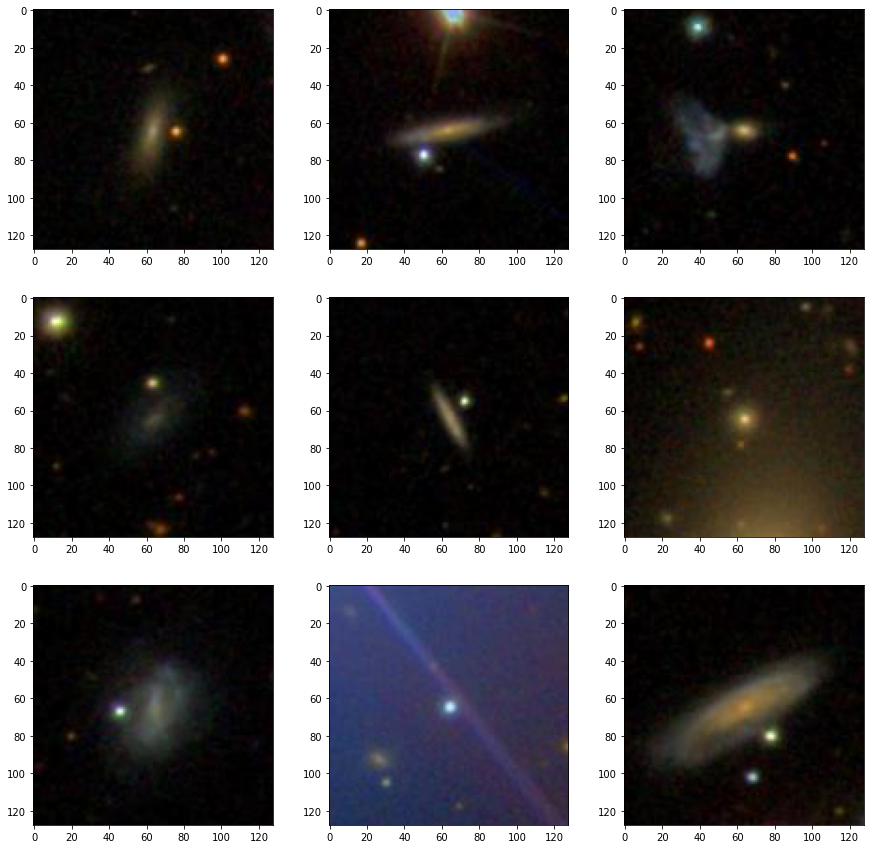

In [60]:
# solution Q4
width, height = 128, 128
scale = 60. / width #  set image scale to that of 1 arcmin
# for subset of subset, student should target the extreme outliers in either A, or As or both.
gals = df.query("As > 0.7")

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()
for i in range(0, 9):
    ra, dec = gals["radec"].iloc[i]
    image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=width, height=height, scale=scale, dataRelease='DR16')
    axs[i].imshow(image)

In [61]:
# Solution depends on the images plotted. Examples of contamination are: satellite trails, and stars close to the galaxy
# Morphological disturbed galaxies should be readily distinguisable as they do not look like "classic" galaxies

22
0
1
2


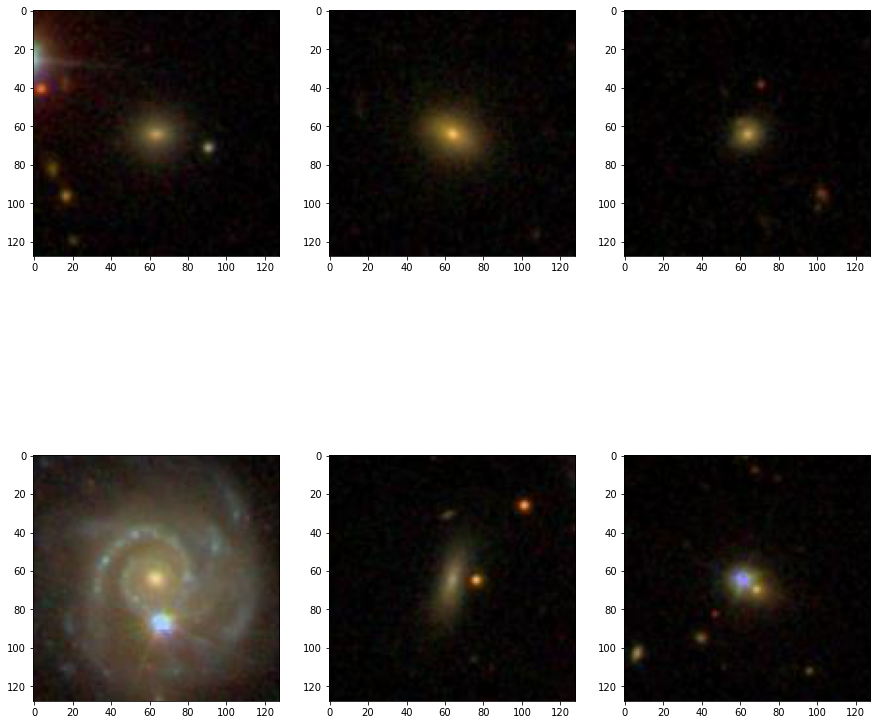

In [28]:
# solution Q
width, height = 128, 128
scale = 60. / width #  set image scale to that of 1 arcmin
# for subset of subset, student should target the extreme outliers in either A, or As or both.
smallA = df.query("A < 0.1")

fig, axs = plt.subplots(2, 3, figsize=(15, 15))
axs = axs.ravel()
for i in range(0, 3):
    ra, dec = smallA["radec"].iloc[i]
    image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=width, height=height, scale=scale, dataRelease='DR16')
    axs[i].imshow(image)
bigA = df.query("A > 0.4")
print(len(bigA.index))
idx = 0
for i in range(3, 6):
    print(idx)
    ra, dec = bigA["radec"].iloc[idx]
    image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=width, height=height, scale=scale, dataRelease='DR16')
    axs[i].imshow(image)
    idx += 1

Text(0, 0.5, 'As90')

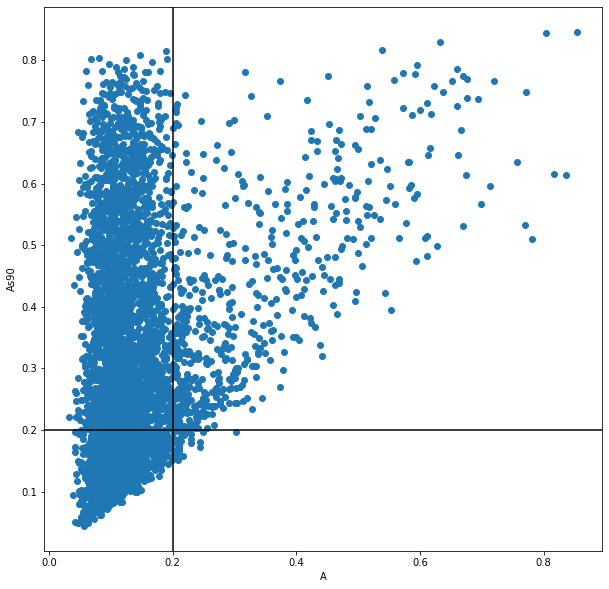

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(df["As"], df["As90"])
ax.axvline(0.2, color="black")
ax.axhline(0.2, color="black")
ax.set_xlabel("A")
ax.set_ylabel("As90")

Number in subset: 143


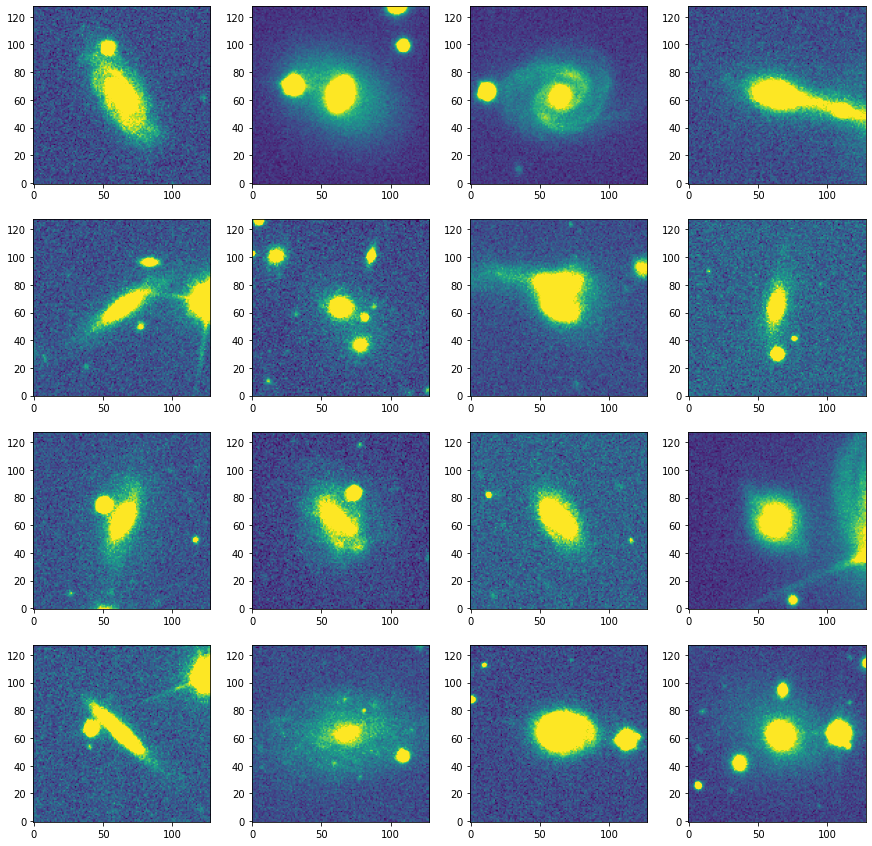

In [61]:
subset = df.query("As90 >= .4 & As >= .4")
rng = np.random.default_rng()
numbers = rng.choice(len(subset.index), size=16, replace=False)

print(f"Number in subset: {len(subset.index)}")

fig = plt.figure(figsize=(15, 15))
subPlotNum = 1
for idx in numbers:
    filename = subset["fname"].iloc[idx]
    ra, dec = subset["radec"].iloc[idx]
    image = pmlsst.image.readImage("sdss", filename, ra=ra, dec=dec, npix=128)

    plt.subplot(4, 4, subPlotNum)
    subPlotNum += 1
    vmin, vmax = zscale.get_limits(image)
    plt.imshow(image, vmin=vmin, vmax=vmax, origin="lower")